## JDSZR6, Jonasz Krawczyk

## zadanie domowe nr 15
treść zadania:

Weź dane z poniższej lokalizacji:
https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv

Wykonaj analizę i model dla tego zbioru:
1. Wytypuj przykładowe zdjęcie lub kilka, spróbuj je wczytać, wykonaj z jednym z nich analogiczne zagadnienia jak podczas zajęć (m.in. zamiana na zdjęcie czarno białe).
2. Po kolejnym zjeździe wczytaj wszystkie zdjęcia i spróbuj stworzyć model sieci neuronowej, który będzie w stanie rozpoznać płeć dziecka ze zdjęcia.

Termin oddania to 1.07.2022 do końca dnia

### 1. import pakietów, ustawienia wstępne

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import random
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, fbeta_score, roc_auc_score
import cv2
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['figure.dpi']= 100

### 2. EDA

In [2]:
df = pd.read_csv("age_gender.csv")

In [3]:
df.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

In [4]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
df.shape

(23705, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


In [8]:
df.isna().any()

age          False
ethnicity    False
gender       False
img_name     False
pixels       False
dtype: bool

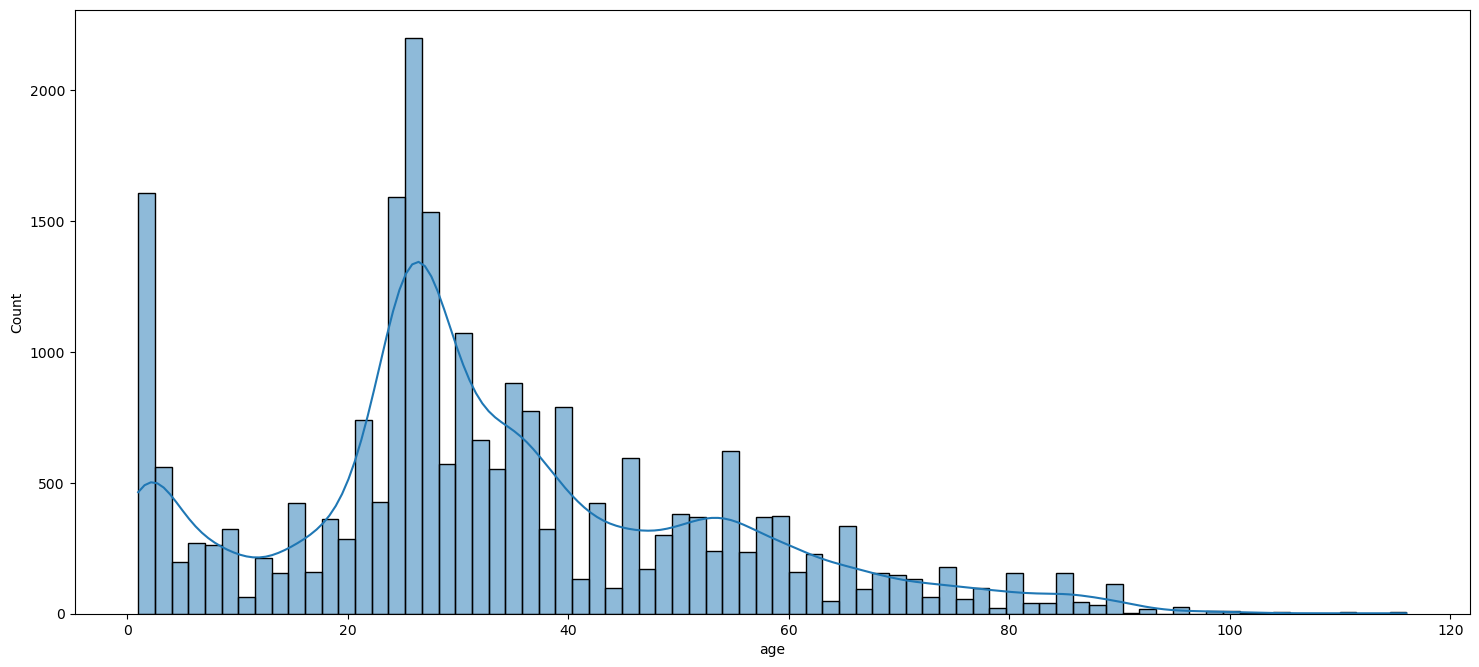

In [9]:
plt.figure(figsize=(18,8))
sns.histplot(df.age, kde=True)
plt.show()

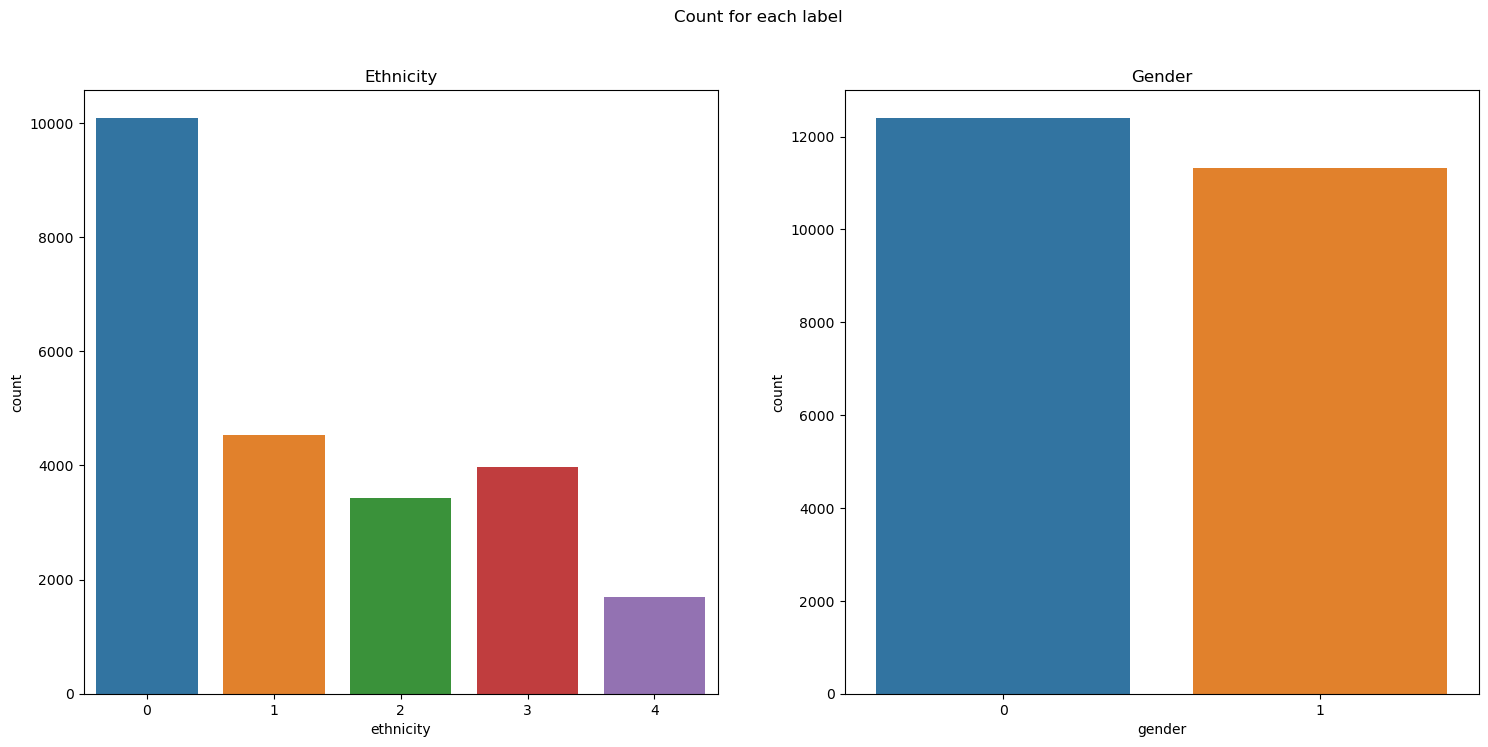

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))
fig.suptitle("Count for each label")

sns.countplot(ax = axes[0], x = df.ethnicity)
axes[0].set_title("Ethnicity")

sns.countplot(ax = axes[1], x = df.gender)
axes[1].set_title("Gender")

plt.show()

In [11]:
df.corr()

,age,ethnicity,gender
age,1.000000,-0.217844,-0.126030
ethnicity,-0.217844,1.000000,0.027364
gender,-0.126030,0.027364,1.000000


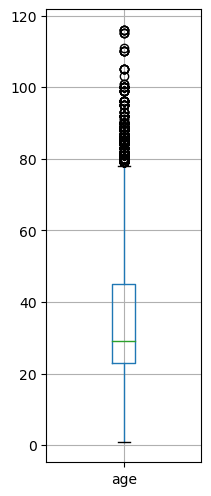

In [12]:
df.boxplot(column='age',figsize=(2,6))
pass

**wnioski z analizy danych**<br>
Zmienna Ethnicity jest niezbalansowana ale na potrzeby określania płci to chyba nie powinien być problem. <br>
Są w tym zbiorze osoby bardzo stare. Choć człowiek może dozyć takiego wieku, podejrzewam błąd w danych; nie chcę brać ich do treningu.

**oglądnę kilka twarzy**<br>
na potrzeby oceny co kryje się pod wartościami zmiennych Ethnicity i Gender.

In [13]:
df['pixels'] = df['pixels'].map(
    lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

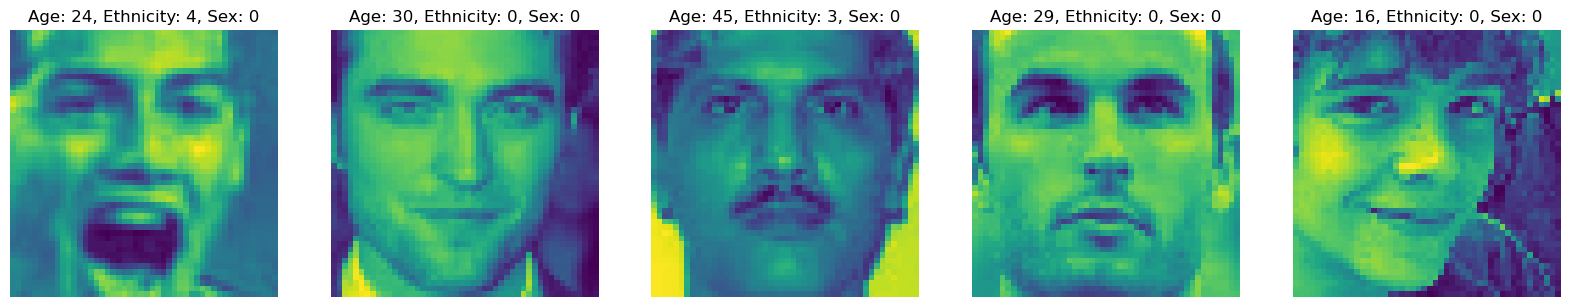

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')

co z tymi seniorami, czy to błąd w danych?

In [15]:
olds = df[df.age > 95]
olds = olds.reset_index()
olds.head()

,index,age,ethnicity,gender,img_name,pixels
0,1279,100,0,0,20170112213500903.jpg.chip.jpg,"[[203.0, 185.0, 139.0, 163.0, 176.0, 184.0, 18..."
1,1280,100,0,0,20170112215240346.jpg.chip.jpg,"[[125.0, 126.0, 115.0, 78.0, 66.0, 66.0, 77.0,..."
2,1281,100,0,1,20170110183726390.jpg.chip.jpg,"[[235.0, 164.0, 113.0, 144.0, 121.0, 201.0, 24..."
3,1282,100,0,1,20170112213001988.jpg.chip.jpg,"[[82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 84.0, 86..."
4,1283,100,0,1,20170112213303693.jpg.chip.jpg,"[[70.0, 72.0, 94.0, 149.0, 154.0, 166.0, 175.0..."


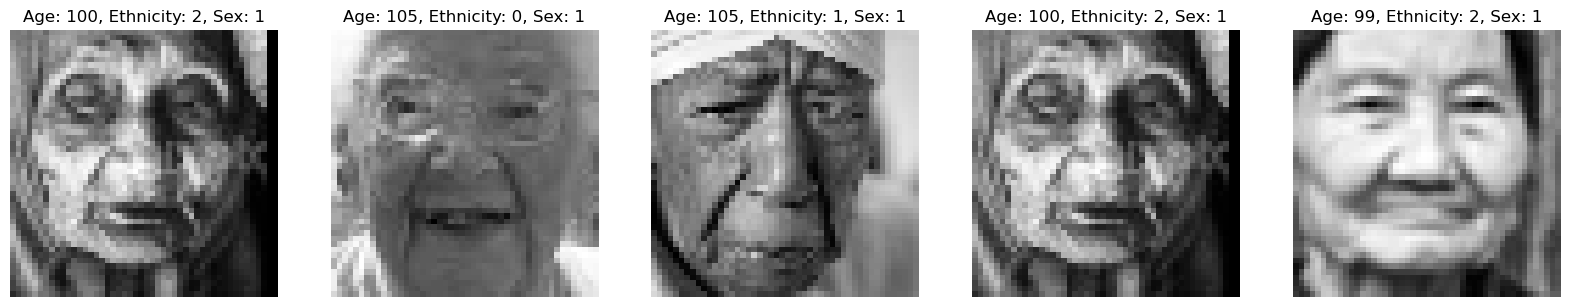

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(olds))
    
    age = olds['age'][random_face]
    ethnicity = olds['ethnicity'][random_face]
    gender = olds['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(olds['pixels'][random_face], cmap = "gray")
    axes[i].axis('off')

In [17]:
olds.gender.value_counts()

1    50
0     8
Name: gender, dtype: int64

**wnioski z przeglądu zdjęć**<br>
Puściłem powyższy kod parę razy. Wydaje się, że Ethnicity określa przynależność do grupy etnicznej, rasy:
* 0 - biały
* 1 - czarny
* 2 - żółty
* 3 - mieszany jakiś
<br><br>
Płeć:
* 0 - on 
* 1 - ona

### 3. obróbka danych

Wiele nie będę tu obrabiał, lekko tylko przytnę DFa

**ludzie starzy**<br>
Oni są tacy. Dataset nie zawiera błędnych danych pod tym kątem. Więcej jest prababć niż pradziadków.<br>
Żaden senior niech się nie obrazi ale usunę tę grupę w ramach czyszczenia danych z outlierów. Takich ludzi jest 58 wobec dwudziestu-paru tysięcy wszystkich. Wygląd superseniorów jest specyficzny, może źle wpływać na uczenie sieci. Delete.

**niemowlęta**<br>
Dzieciaczki bardzo małe mają podobne buźki (w rozróżnieniu płci ale w obrębie tej samej rasy).<br> Dopóki to-to nosi pampera to w zasadzie też jest wszystko jedno jaką ma płeć. Delete.

In [18]:
print("photos in dataset before trim :", len(df))
df = df[(df['age'] >= 3) & (df['age'] < 95)]
print("photos in dataset after trim  :", len(df))

photos in dataset before trim : 23705
photos in dataset after trim  : 22033


In [19]:
df = df.drop('img_name', axis=1)

### 4. podziau zbioru

In [21]:
X = np.array(df['pixels'].tolist())
y = df['gender'].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=997)
x_test = X_test.reshape(-1,48,48,1)
x_train = X_train.reshape(-1,48,48,1)

### 5. budowa sieci klasyfikacyjnej

In [26]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='Adam' ,loss='BinaryCrossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [27]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=148, # w miarę wysoka reszta na ostatnim batchu (0.87), do tego ilość batchy bliska wielkości batcha
    epochs=10,
    validation_split=0.05,
    shuffle=True
)

Epoch 1/10
107/107 [==============================] - 23s 207ms/step - loss: 1.0489 - accuracy: 0.7579 - val_loss: 0.3341 - val_accuracy: 0.8622
Epoch 2/10
107/107 [==============================] - 23s 212ms/step - loss: 0.3026 - accuracy: 0.8739 - val_loss: 0.3206 - val_accuracy: 0.8803
Epoch 3/10
107/107 [==============================] - 29s 268ms/step - loss: 0.2633 - accuracy: 0.8936 - val_loss: 0.3080 - val_accuracy: 0.8694
Epoch 4/10
107/107 [==============================] - 24s 224ms/step - loss: 0.2350 - accuracy: 0.9063 - val_loss: 0.5555 - val_accuracy: 0.7956
Epoch 5/10
107/107 [==============================] - 25s 232ms/step - loss: 0.2357 - accuracy: 0.9064 - val_loss: 0.2654 - val_accuracy: 0.8948
Epoch 6/10
107/107 [==============================] - 22s 201ms/step - loss: 0.2064 - accuracy: 0.9203 - val_loss: 0.2621 - val_accuracy: 0.8936
Epoch 7/10
107/107 [==============================] - 24s 221ms/step - loss: 0.1783 - accuracy: 0.9328 - val_loss: 0.3996 - val_ac

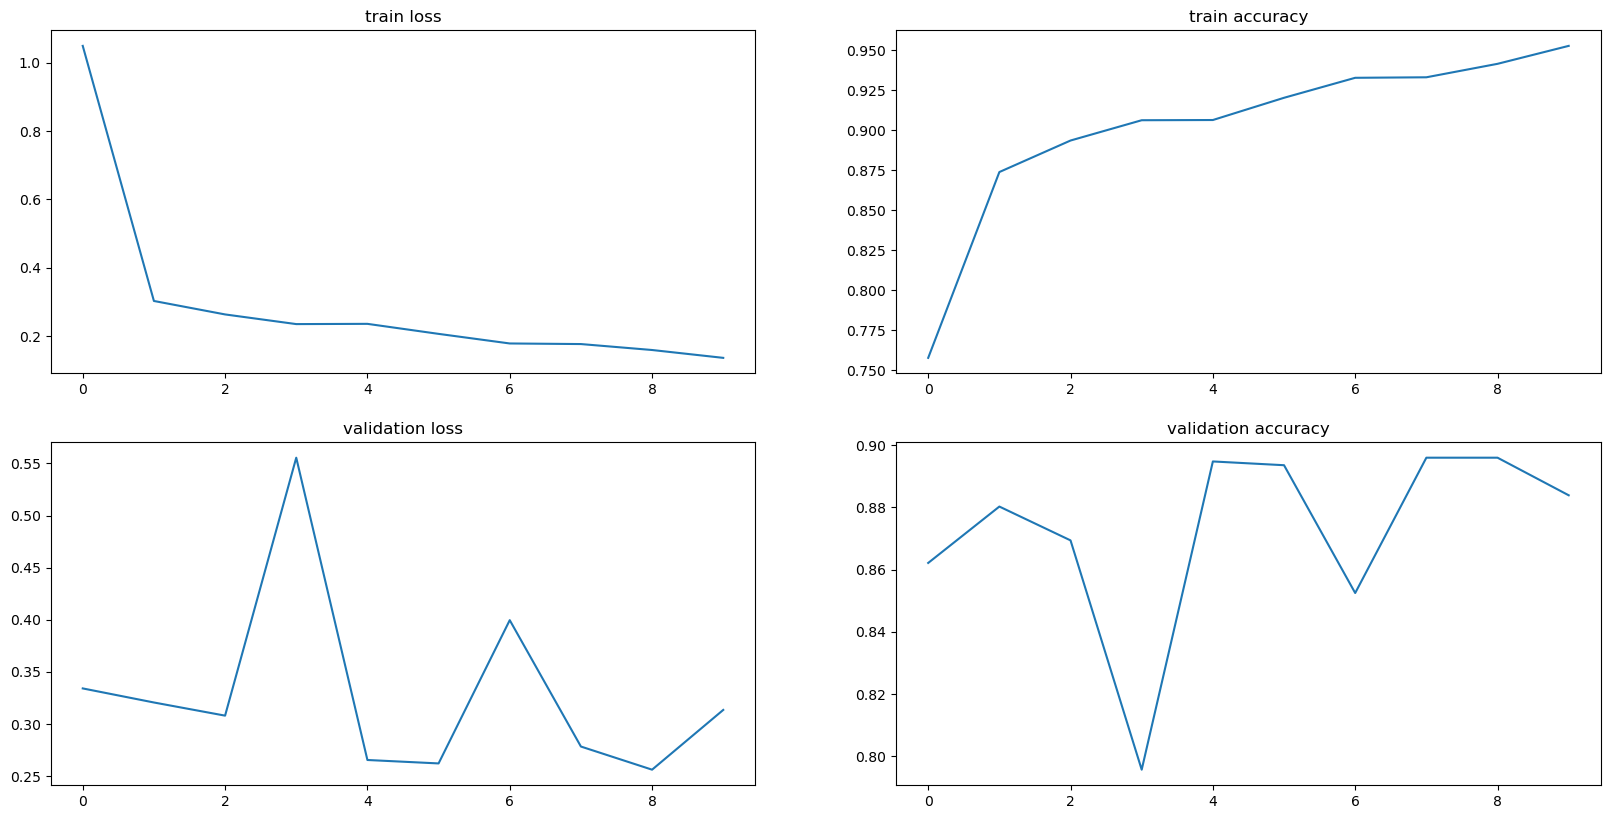

In [28]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

### 6. optymalizacja

Nie widać stabilizacji przegbiegów na zbiorze walidacyjnym. Spróbuję nieco podkręcić wyniki manimulując parametrami.

In [29]:
model2 = Sequential()
model2.add(Conv2D(50,(3,3),activation='relu',input_shape=(48,48,1)))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(100,(3,3),activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(150,(3,3),activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(200,(3,3),activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Flatten())
model2.add(Dense(1,activation='sigmoid'))
model2.compile(optimizer='Adam' ,loss='BinaryCrossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 50)        500       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 50)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 100)       45100     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 100)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 150)         135150    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 150)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 200)        

In [30]:
history2 = model2.fit(
    x=x_train,
    y=y_train,
    batch_size=148, # w miarę wysoka reszta na ostatnim batchu (0.87), do tego ilość batchy bliska wielkości batcha
    epochs=10,
    validation_split=0.05,
    shuffle=True
)

Epoch 1/10
107/107 [==============================] - 54s 490ms/step - loss: 1.3015 - accuracy: 0.6392 - val_loss: 0.5544 - val_accuracy: 0.7291
Epoch 2/10
107/107 [==============================] - 49s 456ms/step - loss: 0.3956 - accuracy: 0.8281 - val_loss: 0.4097 - val_accuracy: 0.8307
Epoch 3/10
107/107 [==============================] - 47s 436ms/step - loss: 0.3279 - accuracy: 0.8623 - val_loss: 0.3280 - val_accuracy: 0.8670
Epoch 4/10
107/107 [==============================] - 53s 498ms/step - loss: 0.2822 - accuracy: 0.8852 - val_loss: 0.4006 - val_accuracy: 0.8283
Epoch 5/10
107/107 [==============================] - 52s 481ms/step - loss: 0.2528 - accuracy: 0.8985 - val_loss: 0.4234 - val_accuracy: 0.8356
Epoch 6/10
107/107 [==============================] - 43s 397ms/step - loss: 0.2377 - accuracy: 0.9065 - val_loss: 0.4099 - val_accuracy: 0.8416
Epoch 7/10
107/107 [==============================] - 42s 397ms/step - loss: 0.2124 - accuracy: 0.9188 - val_loss: 0.3544 - val_ac

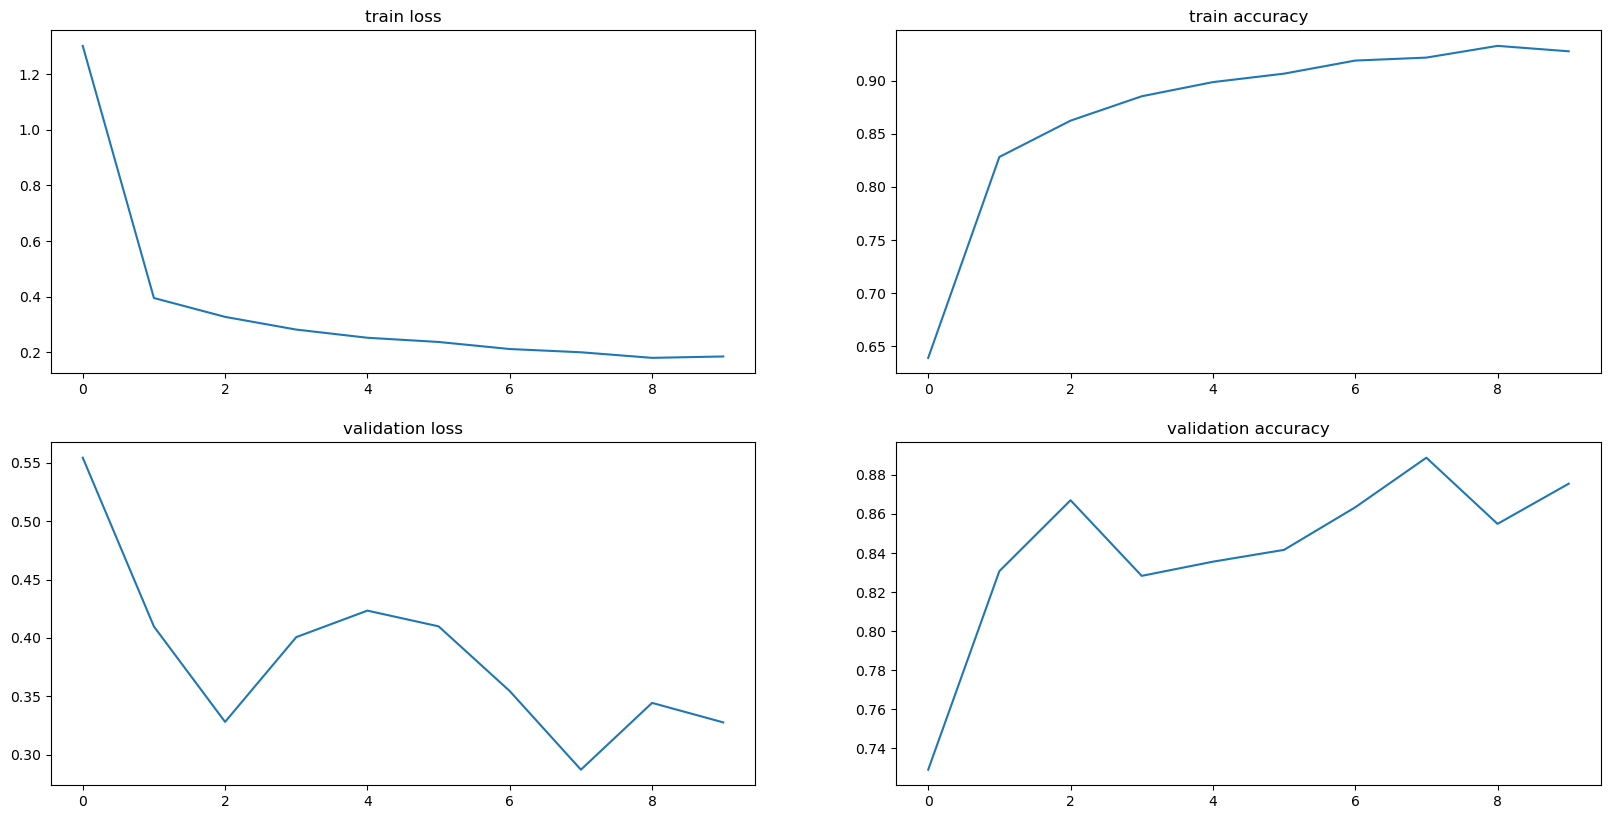

In [31]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
ax[0][0].plot(history2.history["loss"])
ax[0][1].plot(history2.history["accuracy"])
ax[1][0].plot(history2.history["val_loss"])
ax[1][1].plot(history2.history["val_accuracy"])
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

### 7. wnioski

Wartości funkcji kosztu i accuracy zasadniczo nie zmieniły się jakoś znacznie. Przebiegi zostały nieco wygładzone co uznaję za zmianę w dobry kierunki. W dalszej pracy nad modelem na początek należałoby zwiększyć ilość epok aby doglądnąć jak sprawa się rozwija.

## BRUDNOPIS